<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install --upgrade -q lightgbm
!pip install --upgrade -q wordcloud

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# Загрузка необходимых ресурсов nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
try:
    # Попробуем загрузить файл локально
    data = pd.read_csv('toxic_comments.csv')
    display("Данные успешно загружены локально")
except FileNotFoundError:
    # Если локальный файл не найден, загружаем по ссылке
    display("Локальный файл не найден. Пытаюсь загрузить из сети...")
    
    try:
        # Загрузка данных из сети по ссылке
        data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
        display("Данные успешно загружены из сети")
    except Exception as e:
        # Обработка любых ошибок, связанных с загрузкой по сети
        display(f"Не удалось загрузить данные из сети. Ошибка: {e}")

'Локальный файл не найден. Пытаюсь загрузить из сети...'

'Данные успешно загружены из сети'

In [4]:
# Посмотрим на первые строки датасета
display(data.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# Посмотрим на информацию о столбцах
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Удалим столбец "Unnamed: 0", так как он дублирует индексы

In [6]:
data = data.drop('Unnamed: 0', axis=1)

Для продолжения работы удалим из текста разделители и знаки препинания, а также преобразуем все буквы в строчные.

In [7]:
def clean(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

data['text'] = data['text'].apply(clean)

In [8]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


Посчитаем среднюю длину слов: 

In [9]:
data['char_count'] = data['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
data['char_count'].median()

4.550271939936744

Наиболее часто встерчаемая длина слова 4-5 буквы.

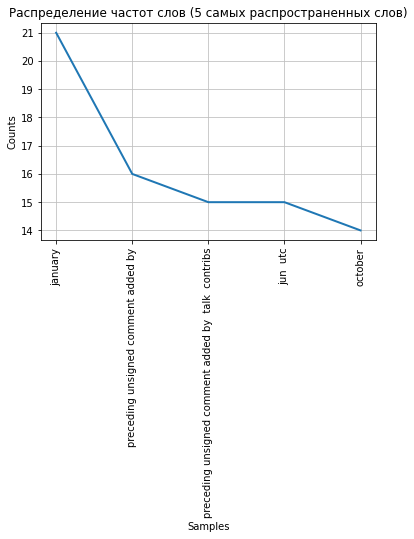

In [10]:
fdist = FreqDist(data['text'])
fdist.plot(5, cumulative=False, title='Распределение частот слов (5 самых распространенных слов)');

Наиболее часто встречающиеся слова и предложения включают названия некоторых месяцев года, а также сведения, связанные с комментариями (например, ответы на комментарии).

Теперь выполним лемматизацию:

In [11]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_pos):
    if treebank_pos.startswith('J'):
        return 'a'  # adjective
    elif treebank_pos.startswith('V'):
        return 'v'  # verb
    elif treebank_pos.startswith('N'):
        return 'n'  # noun
    elif treebank_pos.startswith('R'):
        return 'r'  # adverb
    else:
        return None

def lemmatize(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatized_words = []
    
    for word, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)
        if wordnet_pos:  # Если POS-тег определён
            lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)  # По умолчанию noun
        lemmatized_words.append(lemmatized_word)
    
    return ' '.join(lemmatized_words)
corpus = data['text']
# Применяем лемматизацию к каждому элементу корпуса
lemmatized_corpus = [lemmatize(text) for text in corpus]
print(lemmatized_corpus[0])

explanation why the edits make under my username hardcore metallica fan be revert they werent vandalism just closure on some gas after i vote at new york doll fac and please dont remove the template from the talk page since im retire now


Обозначим список стоп слов из английского словаря:

In [12]:
stopwords = nltk_stopwords.words('english')

**Вывод:** данные включают текстовую информацию, прошедшую предварительную очистку. Были определены наиболее частая длина слов и топ-5 популярных слов, а также выполнена лемматизация. Теперь перейдем к обучению модели.

## Обучение

Разделим датафрейм на выборки:

In [13]:
target = data['toxic'].values
features = data['text']
f_train, f_test, t_train, t_test = train_test_split(features, target, test_size=0.1, random_state=42, stratify=target)
f"Размер тренировочной выборки: {f_train.shape[0]}, тестовой выборки: {f_test.shape[0]}"

'Размер тренировочной выборки: 143362, тестовой выборки: 15930'

In [14]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(random_state=1, solver='liblinear', max_iter=200))
])

param_grid = [
    {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1', 'l2'],
        'model__max_iter': [100, 200],
        'tfidf__ngram_range': [(1, 1), (1, 2)],  
        'tfidf__min_df': [1, 5],
    }
]

# Настраиваем GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1, error_score='raise')
best_grid = grid.fit(f_train, t_train)
print('Лучшие параметры модели логистической регрессии:', grid.best_params_)
print('Лучшая оценка:', grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры модели логистической регрессии: {'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Лучшая оценка: 0.7715621841119487


Обучим LGBM_model:

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(f_train)
tfidf_test = tfidf_vectorizer.transform(f_test)
lgr = LGBMClassifier(objective='binary', random_state=42)
param_dist = {
    'learning_rate': [0.1, 0.5],         
    'n_estimators': [100, 200],                  
    'max_depth': [-1, 5, 10]                        
}

# Настройка GridSearchCV
LGBM_model = GridSearchCV(lgr, param_grid=param_dist, cv=3, scoring='f1', verbose=5, n_jobs=-1)

# Обучение модели
LGBM_model.fit(tfidf_train, t_train)

# Вывод лучших параметров и лучшей оценки
print('Лучшие параметры классификатора:', LGBM_model.best_params_)
print('Лучшая оценка:', LGBM_model.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 9711, number of negative: 85863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 22.723298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472633
[LightGBM] [Info] Number of data points in the train set: 95574, number of used features: 9996
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101607 -> initscore=-2.179494
[LightGBM] [Info] Start training from score -2.179494
[CV 1/3] END learning_rate=0.1, max_depth=-1, n_estimators=100; total time= 1.2min
[LightGBM] [Info] Number of positive: 9712, number of negative: 85863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 22.427029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

Наилучший результат был достигнут с использованием модели логистической регрессии. Теперь выполним предсказания с её помощью:

In [16]:
t_pred = grid.predict(f_test)
f1 = f1_score(t_test, t_pred)
f1

0.7813234800134364

**Вывод:** результаты оценки модели на тестовых данных оказались лучше, чем на тренировочных, что свидетельствует о корректном выборе параметров модели.

## Выводы

Проект успешно завершен с достижением требуемого уровня точности F1. Использованные методы показали свою эффективность в задаче классификации токсичных комментариев. Рекомендуется продолжить исследование и оптимизацию модели, применяя новые данные и потенциальные гиперпараметры, что может способствовать дальнейшему улучшению качества и надежности классификации.